<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:35] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


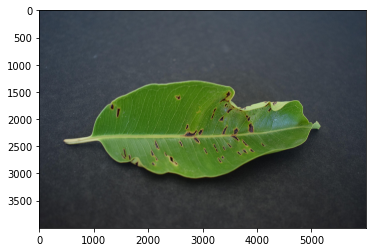

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

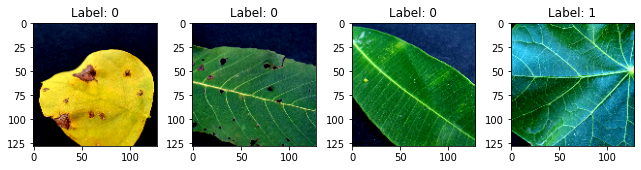

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:41] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2526823461123406 samples/sec                   batch loss = 1.0638395547866821 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2623315762343426 samples/sec                   batch loss = 0.3665317893028259 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2656638501350177 samples/sec                   batch loss = 1.0456501245498657 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2646272989244363 samples/sec                   batch loss = 0.714723527431488 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2674190250767 samples/sec                   batch loss = 0.4925415813922882 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2227514402874686 samples/sec                   batch loss = 0.8282951712608337 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2649135282859885 samples/sec                   batch loss = 1.0586543083190918 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2685932875137382 samples/sec                   batch loss = 0.5072253942489624 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.268096885980533 samples/sec                   batch loss = 0.7474154829978943 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2698530533188364 samples/sec                   batch loss = 0.4649578332901001 | accuracy = 0.64


Epoch[1] Batch[55] Speed: 1.268992838682355 samples/sec                   batch loss = 0.7955583333969116 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2620817362867636 samples/sec                   batch loss = 1.124144434928894 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2625951026209368 samples/sec                   batch loss = 0.1275520622730255 | accuracy = 0.6307692307692307


Epoch[1] Batch[70] Speed: 1.2638389791789786 samples/sec                   batch loss = 0.5365377068519592 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.2640050399828646 samples/sec                   batch loss = 0.1399158090353012 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.2628102612305832 samples/sec                   batch loss = 0.13597461581230164 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2604694171998632 samples/sec                   batch loss = 0.5508854985237122 | accuracy = 0.6470588235294118


Epoch[1] Batch[90] Speed: 1.2614375089708127 samples/sec                   batch loss = 0.3101286292076111 | accuracy = 0.65


Epoch[1] Batch[95] Speed: 1.264660758761057 samples/sec                   batch loss = 0.3103405237197876 | accuracy = 0.6578947368421053


Epoch[1] Batch[100] Speed: 1.2690465919499292 samples/sec                   batch loss = 0.19838222861289978 | accuracy = 0.6625


Epoch[1] Batch[105] Speed: 1.2612769578785379 samples/sec                   batch loss = 0.8518111109733582 | accuracy = 0.6666666666666666


Epoch[1] Batch[110] Speed: 1.2612033816684416 samples/sec                   batch loss = 0.563940167427063 | accuracy = 0.6590909090909091


Epoch[1] Batch[115] Speed: 1.260217189931372 samples/sec                   batch loss = 0.19946016371250153 | accuracy = 0.6543478260869565


Epoch[1] Batch[120] Speed: 1.257973184378989 samples/sec                   batch loss = 0.4985969066619873 | accuracy = 0.6520833333333333


Epoch[1] Batch[125] Speed: 1.2580325170636788 samples/sec                   batch loss = 0.28215649724006653 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2595694740807708 samples/sec                   batch loss = 0.3267536163330078 | accuracy = 0.6538461538461539


Epoch[1] Batch[135] Speed: 1.2637499679867186 samples/sec                   batch loss = 0.4531041979789734 | accuracy = 0.6537037037037037


Epoch[1] Batch[140] Speed: 1.2666195720063238 samples/sec                   batch loss = 0.5982699394226074 | accuracy = 0.6517857142857143


Epoch[1] Batch[145] Speed: 1.261006588537427 samples/sec                   batch loss = 0.3317895829677582 | accuracy = 0.6603448275862069


Epoch[1] Batch[150] Speed: 1.266144110656718 samples/sec                   batch loss = 1.1785988807678223 | accuracy = 0.6583333333333333


Epoch[1] Batch[155] Speed: 1.2648339965389968 samples/sec                   batch loss = 0.5241691470146179 | accuracy = 0.6645161290322581


Epoch[1] Batch[160] Speed: 1.266254771225344 samples/sec                   batch loss = 0.3820060193538666 | accuracy = 0.6703125


Epoch[1] Batch[165] Speed: 1.2690425602968993 samples/sec                   batch loss = 0.5989586710929871 | accuracy = 0.6712121212121213


Epoch[1] Batch[170] Speed: 1.2639021038045246 samples/sec                   batch loss = 1.0045584440231323 | accuracy = 0.6676470588235294


Epoch[1] Batch[175] Speed: 1.2640098015438999 samples/sec                   batch loss = 0.7614050507545471 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.2723734476060697 samples/sec                   batch loss = 0.41714537143707275 | accuracy = 0.6666666666666666


Epoch[1] Batch[185] Speed: 1.2609120056036471 samples/sec                   batch loss = 0.5491644740104675 | accuracy = 0.6716216216216216


Epoch[1] Batch[190] Speed: 1.2655729587722115 samples/sec                   batch loss = 0.40136265754699707 | accuracy = 0.6710526315789473


Epoch[1] Batch[195] Speed: 1.2563840404362188 samples/sec                   batch loss = 0.8975695967674255 | accuracy = 0.6692307692307692


Epoch[1] Batch[200] Speed: 1.2574278500381637 samples/sec                   batch loss = 0.6767844557762146 | accuracy = 0.67125


Epoch[1] Batch[205] Speed: 1.2562142381892898 samples/sec                   batch loss = 0.5545008182525635 | accuracy = 0.6695121951219513


Epoch[1] Batch[210] Speed: 1.264463266484784 samples/sec                   batch loss = 0.5218860507011414 | accuracy = 0.6702380952380952


Epoch[1] Batch[215] Speed: 1.267154342729077 samples/sec                   batch loss = 0.36206796765327454 | accuracy = 0.6709302325581395


Epoch[1] Batch[220] Speed: 1.2648471557778276 samples/sec                   batch loss = 0.70088791847229 | accuracy = 0.6727272727272727


Epoch[1] Batch[225] Speed: 1.2635596118014059 samples/sec                   batch loss = 0.9063635468482971 | accuracy = 0.6711111111111111


Epoch[1] Batch[230] Speed: 1.2649285012083278 samples/sec                   batch loss = 0.7558672428131104 | accuracy = 0.6739130434782609


Epoch[1] Batch[235] Speed: 1.2608610238958533 samples/sec                   batch loss = 0.4299647808074951 | accuracy = 0.676595744680851


Epoch[1] Batch[240] Speed: 1.262582845349628 samples/sec                   batch loss = 0.4124971032142639 | accuracy = 0.68125


Epoch[1] Batch[245] Speed: 1.2603786075403431 samples/sec                   batch loss = 0.39338526129722595 | accuracy = 0.6816326530612244


Epoch[1] Batch[250] Speed: 1.2580896854846275 samples/sec                   batch loss = 0.29201576113700867 | accuracy = 0.682


Epoch[1] Batch[255] Speed: 1.2612609334624072 samples/sec                   batch loss = 0.5391910672187805 | accuracy = 0.6813725490196079


Epoch[1] Batch[260] Speed: 1.2687636704935288 samples/sec                   batch loss = 0.4649026095867157 | accuracy = 0.6826923076923077


Epoch[1] Batch[265] Speed: 1.267399397454794 samples/sec                   batch loss = 0.4495268762111664 | accuracy = 0.6820754716981132


Epoch[1] Batch[270] Speed: 1.2599788787090869 samples/sec                   batch loss = 0.3922969400882721 | accuracy = 0.6824074074074075


Epoch[1] Batch[275] Speed: 1.2562776382014906 samples/sec                   batch loss = 1.1417938470840454 | accuracy = 0.6809090909090909


Epoch[1] Batch[280] Speed: 1.2597348876746473 samples/sec                   batch loss = 0.580883264541626 | accuracy = 0.6803571428571429


Epoch[1] Batch[285] Speed: 1.2646381660276595 samples/sec                   batch loss = 0.5536571145057678 | accuracy = 0.6798245614035088


Epoch[1] Batch[290] Speed: 1.2612038557144833 samples/sec                   batch loss = 0.28367018699645996 | accuracy = 0.6801724137931034


Epoch[1] Batch[295] Speed: 1.2559482912600688 samples/sec                   batch loss = 0.5614680647850037 | accuracy = 0.6796610169491526


Epoch[1] Batch[300] Speed: 1.2675038616931373 samples/sec                   batch loss = 0.5173065066337585 | accuracy = 0.6816666666666666


Epoch[1] Batch[305] Speed: 1.2731289771488545 samples/sec                   batch loss = 0.9345712065696716 | accuracy = 0.6811475409836065


Epoch[1] Batch[310] Speed: 1.2692244901417546 samples/sec                   batch loss = 0.6516944169998169 | accuracy = 0.6806451612903226


Epoch[1] Batch[315] Speed: 1.2635657974758383 samples/sec                   batch loss = 0.40523070096969604 | accuracy = 0.680952380952381


Epoch[1] Batch[320] Speed: 1.261915516005632 samples/sec                   batch loss = 0.28507450222969055 | accuracy = 0.68203125


Epoch[1] Batch[325] Speed: 1.265605132058164 samples/sec                   batch loss = 1.1610409021377563 | accuracy = 0.6838461538461539


Epoch[1] Batch[330] Speed: 1.26188950948353 samples/sec                   batch loss = 0.44761982560157776 | accuracy = 0.6840909090909091


Epoch[1] Batch[335] Speed: 1.2670065899051453 samples/sec                   batch loss = 0.738309383392334 | accuracy = 0.6835820895522388


Epoch[1] Batch[340] Speed: 1.2667743125306505 samples/sec                   batch loss = 0.5595353841781616 | accuracy = 0.6838235294117647


Epoch[1] Batch[345] Speed: 1.2684048258791474 samples/sec                   batch loss = 0.6326471567153931 | accuracy = 0.6855072463768116


Epoch[1] Batch[350] Speed: 1.2655612164076537 samples/sec                   batch loss = 0.5015519857406616 | accuracy = 0.6864285714285714


Epoch[1] Batch[355] Speed: 1.2620532545464775 samples/sec                   batch loss = 0.2751479148864746 | accuracy = 0.6852112676056338


Epoch[1] Batch[360] Speed: 1.2626311156707837 samples/sec                   batch loss = 0.4875444173812866 | accuracy = 0.6840277777777778


Epoch[1] Batch[365] Speed: 1.2651294778536948 samples/sec                   batch loss = 0.376309335231781 | accuracy = 0.684931506849315


Epoch[1] Batch[370] Speed: 1.2576651028701638 samples/sec                   batch loss = 0.7083547115325928 | accuracy = 0.6871621621621622


Epoch[1] Batch[375] Speed: 1.2568136898262403 samples/sec                   batch loss = 1.1080844402313232 | accuracy = 0.6873333333333334


Epoch[1] Batch[380] Speed: 1.2566602435029697 samples/sec                   batch loss = 0.5142226815223694 | accuracy = 0.6875


Epoch[1] Batch[385] Speed: 1.2597047146603204 samples/sec                   batch loss = 0.3689475953578949 | accuracy = 0.6902597402597402


Epoch[1] Batch[390] Speed: 1.259358537844787 samples/sec                   batch loss = 0.6692878603935242 | accuracy = 0.6897435897435897


Epoch[1] Batch[395] Speed: 1.2583222805603298 samples/sec                   batch loss = 0.5224538445472717 | accuracy = 0.6879746835443038


Epoch[1] Batch[400] Speed: 1.2563136680629439 samples/sec                   batch loss = 0.3393931984901428 | accuracy = 0.690625


Epoch[1] Batch[405] Speed: 1.2598632573725494 samples/sec                   batch loss = 0.5015606880187988 | accuracy = 0.6919753086419753


Epoch[1] Batch[410] Speed: 1.2583661671644089 samples/sec                   batch loss = 0.34239184856414795 | accuracy = 0.6926829268292682


Epoch[1] Batch[415] Speed: 1.2608328814849634 samples/sec                   batch loss = 1.261460542678833 | accuracy = 0.694578313253012


Epoch[1] Batch[420] Speed: 1.2580014822586358 samples/sec                   batch loss = 0.15356793999671936 | accuracy = 0.6946428571428571


Epoch[1] Batch[425] Speed: 1.2610528426728114 samples/sec                   batch loss = 0.6889146566390991 | accuracy = 0.6947058823529412


Epoch[1] Batch[430] Speed: 1.2654371234360433 samples/sec                   batch loss = 0.21904365718364716 | accuracy = 0.6953488372093023


Epoch[1] Batch[435] Speed: 1.2587464571248805 samples/sec                   batch loss = 0.8238980174064636 | accuracy = 0.6948275862068966


Epoch[1] Batch[440] Speed: 1.2707453302206269 samples/sec                   batch loss = 0.9985741972923279 | accuracy = 0.6943181818181818


Epoch[1] Batch[445] Speed: 1.268142511471867 samples/sec                   batch loss = 0.8956050276756287 | accuracy = 0.6938202247191011


Epoch[1] Batch[450] Speed: 1.260312047352327 samples/sec                   batch loss = 0.739000141620636 | accuracy = 0.6944444444444444


Epoch[1] Batch[455] Speed: 1.2602905564460098 samples/sec                   batch loss = 0.7053518295288086 | accuracy = 0.6939560439560439


Epoch[1] Batch[460] Speed: 1.2584949188649912 samples/sec                   batch loss = 0.2068280279636383 | accuracy = 0.6945652173913044


Epoch[1] Batch[465] Speed: 1.2629582728535895 samples/sec                   batch loss = 0.6038377285003662 | accuracy = 0.693010752688172


Epoch[1] Batch[470] Speed: 1.2609274525482288 samples/sec                   batch loss = 0.48566803336143494 | accuracy = 0.6920212765957446


Epoch[1] Batch[475] Speed: 1.263517360506527 samples/sec                   batch loss = 0.3406790494918823 | accuracy = 0.6910526315789474


Epoch[1] Batch[480] Speed: 1.263371120522788 samples/sec                   batch loss = 0.501640260219574 | accuracy = 0.6927083333333334


Epoch[1] Batch[485] Speed: 1.2637130344028018 samples/sec                   batch loss = 0.2955978810787201 | accuracy = 0.6943298969072165


Epoch[1] Batch[490] Speed: 1.2540477219672144 samples/sec                   batch loss = 0.4370989203453064 | accuracy = 0.6943877551020409


Epoch[1] Batch[495] Speed: 1.25496344480749 samples/sec                   batch loss = 0.2506847083568573 | accuracy = 0.6954545454545454


Epoch[1] Batch[500] Speed: 1.2598156714486282 samples/sec                   batch loss = 1.4603297710418701 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2636424096944536 samples/sec                   batch loss = 0.2792414426803589 | accuracy = 0.6955445544554455


Epoch[1] Batch[510] Speed: 1.259861365219473 samples/sec                   batch loss = 0.5398723483085632 | accuracy = 0.6965686274509804


Epoch[1] Batch[515] Speed: 1.2598870989882884 samples/sec                   batch loss = 0.2456149458885193 | accuracy = 0.6980582524271844


Epoch[1] Batch[520] Speed: 1.260698345904211 samples/sec                   batch loss = 0.3566063344478607 | accuracy = 0.6990384615384615


Epoch[1] Batch[525] Speed: 1.2608244484818898 samples/sec                   batch loss = 0.43039143085479736 | accuracy = 0.6976190476190476


Epoch[1] Batch[530] Speed: 1.2587532568517588 samples/sec                   batch loss = 0.5110104084014893 | accuracy = 0.6995283018867925


Epoch[1] Batch[535] Speed: 1.2626959253311287 samples/sec                   batch loss = 0.6603400111198425 | accuracy = 0.6985981308411215


Epoch[1] Batch[540] Speed: 1.2616684024379359 samples/sec                   batch loss = 0.749120831489563 | accuracy = 0.6986111111111111


Epoch[1] Batch[545] Speed: 1.2597057550850288 samples/sec                   batch loss = 1.178529143333435 | accuracy = 0.6977064220183486


Epoch[1] Batch[550] Speed: 1.2554550642371352 samples/sec                   batch loss = 0.3930262625217438 | accuracy = 0.6995454545454546


Epoch[1] Batch[555] Speed: 1.25919473518223 samples/sec                   batch loss = 0.41084563732147217 | accuracy = 0.6990990990990991


Epoch[1] Batch[560] Speed: 1.2577274236823344 samples/sec                   batch loss = 0.2510843575000763 | accuracy = 0.7008928571428571


Epoch[1] Batch[565] Speed: 1.2595798761713108 samples/sec                   batch loss = 0.3207952678203583 | accuracy = 0.7008849557522124


Epoch[1] Batch[570] Speed: 1.2563814060342224 samples/sec                   batch loss = 0.4015946090221405 | accuracy = 0.7


Epoch[1] Batch[575] Speed: 1.261899190618336 samples/sec                   batch loss = 0.7481073141098022 | accuracy = 0.7


Epoch[1] Batch[580] Speed: 1.255570817488289 samples/sec                   batch loss = 0.2657569944858551 | accuracy = 0.7004310344827587


Epoch[1] Batch[585] Speed: 1.2598967494226267 samples/sec                   batch loss = 1.7927074432373047 | accuracy = 0.6991452991452991


Epoch[1] Batch[590] Speed: 1.2561908175482888 samples/sec                   batch loss = 0.42637524008750916 | accuracy = 0.6995762711864407


Epoch[1] Batch[595] Speed: 1.2513402862613825 samples/sec                   batch loss = 0.41204068064689636 | accuracy = 0.7


Epoch[1] Batch[600] Speed: 1.2545456598416183 samples/sec                   batch loss = 0.46712470054626465 | accuracy = 0.7


Epoch[1] Batch[605] Speed: 1.2612199734919436 samples/sec                   batch loss = 0.454514741897583 | accuracy = 0.7008264462809918


Epoch[1] Batch[610] Speed: 1.2639471422709125 samples/sec                   batch loss = 0.5795532464981079 | accuracy = 0.7020491803278689


Epoch[1] Batch[615] Speed: 1.263364175679231 samples/sec                   batch loss = 0.5810551047325134 | accuracy = 0.7004065040650407


Epoch[1] Batch[620] Speed: 1.2598505800554636 samples/sec                   batch loss = 0.2733146548271179 | accuracy = 0.7016129032258065


Epoch[1] Batch[625] Speed: 1.2615654670130858 samples/sec                   batch loss = 0.5107502341270447 | accuracy = 0.702


Epoch[1] Batch[630] Speed: 1.257215557799136 samples/sec                   batch loss = 0.45390084385871887 | accuracy = 0.7015873015873015


Epoch[1] Batch[635] Speed: 1.2588529001640532 samples/sec                   batch loss = 0.32497653365135193 | accuracy = 0.7023622047244095


Epoch[1] Batch[640] Speed: 1.2532114951859878 samples/sec                   batch loss = 1.1265761852264404 | accuracy = 0.70234375


Epoch[1] Batch[645] Speed: 1.261526763843907 samples/sec                   batch loss = 0.3748140335083008 | accuracy = 0.7027131782945737


Epoch[1] Batch[650] Speed: 1.2544556078946913 samples/sec                   batch loss = 0.30946457386016846 | accuracy = 0.7042307692307692


Epoch[1] Batch[655] Speed: 1.2608086250614445 samples/sec                   batch loss = 0.8360620141029358 | accuracy = 0.7049618320610687


Epoch[1] Batch[660] Speed: 1.2655420281345449 samples/sec                   batch loss = 0.7187739610671997 | accuracy = 0.7053030303030303


Epoch[1] Batch[665] Speed: 1.2550313189007214 samples/sec                   batch loss = 1.7312042713165283 | accuracy = 0.7045112781954888


Epoch[1] Batch[670] Speed: 1.261362586363731 samples/sec                   batch loss = 0.7355072498321533 | accuracy = 0.7041044776119403


Epoch[1] Batch[675] Speed: 1.2584177968303611 samples/sec                   batch loss = 0.32271990180015564 | accuracy = 0.7051851851851851


Epoch[1] Batch[680] Speed: 1.2565233972324337 samples/sec                   batch loss = 0.47959232330322266 | accuracy = 0.705514705882353


Epoch[1] Batch[685] Speed: 1.2610195734746592 samples/sec                   batch loss = 0.38733747601509094 | accuracy = 0.7062043795620438


Epoch[1] Batch[690] Speed: 1.261347413248616 samples/sec                   batch loss = 1.3046015501022339 | accuracy = 0.7061594202898551


Epoch[1] Batch[695] Speed: 1.262336705114132 samples/sec                   batch loss = 0.5984219312667847 | accuracy = 0.7053956834532374


Epoch[1] Batch[700] Speed: 1.2643016584768576 samples/sec                   batch loss = 0.5910652279853821 | accuracy = 0.7042857142857143


Epoch[1] Batch[705] Speed: 1.2637537756954436 samples/sec                   batch loss = 1.5446867942810059 | accuracy = 0.7028368794326241


Epoch[1] Batch[710] Speed: 1.2590777458678437 samples/sec                   batch loss = 0.5832128524780273 | accuracy = 0.7045774647887324


Epoch[1] Batch[715] Speed: 1.2626278848647507 samples/sec                   batch loss = 0.6275835633277893 | accuracy = 0.7048951048951049


Epoch[1] Batch[720] Speed: 1.264165714868709 samples/sec                   batch loss = 0.5644972920417786 | accuracy = 0.7052083333333333


Epoch[1] Batch[725] Speed: 1.25519056550556 samples/sec                   batch loss = 0.5994123220443726 | accuracy = 0.7051724137931035


Epoch[1] Batch[730] Speed: 1.2621959609797861 samples/sec                   batch loss = 0.34382113814353943 | accuracy = 0.7061643835616438


Epoch[1] Batch[735] Speed: 1.2593190247049886 samples/sec                   batch loss = 0.3657996952533722 | accuracy = 0.7071428571428572


Epoch[1] Batch[740] Speed: 1.2544212789937723 samples/sec                   batch loss = 0.3649832308292389 | accuracy = 0.7084459459459459


Epoch[1] Batch[745] Speed: 1.2567219940820893 samples/sec                   batch loss = 0.6056618094444275 | accuracy = 0.7083892617449664


Epoch[1] Batch[750] Speed: 1.2569206537191846 samples/sec                   batch loss = 0.33425575494766235 | accuracy = 0.7086666666666667


Epoch[1] Batch[755] Speed: 1.2607448616497428 samples/sec                   batch loss = 0.5366811156272888 | accuracy = 0.7086092715231788


Epoch[1] Batch[760] Speed: 1.2611963658286864 samples/sec                   batch loss = 0.371935099363327 | accuracy = 0.7092105263157895


Epoch[1] Batch[765] Speed: 1.2576185312880772 samples/sec                   batch loss = 1.7399998903274536 | accuracy = 0.7084967320261438


Epoch[1] Batch[770] Speed: 1.256322793447227 samples/sec                   batch loss = 0.5761919617652893 | accuracy = 0.7090909090909091


Epoch[1] Batch[775] Speed: 1.2591758339821641 samples/sec                   batch loss = 0.48100346326828003 | accuracy = 0.7096774193548387


Epoch[1] Batch[780] Speed: 1.2561952382449881 samples/sec                   batch loss = 0.36479851603507996 | accuracy = 0.7105769230769231


Epoch[1] Batch[785] Speed: 1.2586096282359438 samples/sec                   batch loss = 0.3755178153514862 | accuracy = 0.710828025477707


[Epoch 1] training: accuracy=0.7112944162436549
[Epoch 1] time cost: 651.4441423416138
[Epoch 1] validation: validation accuracy=0.7233333333333334


Epoch[2] Batch[5] Speed: 1.2631964761360435 samples/sec                   batch loss = 0.40045952796936035 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2628591192918686 samples/sec                   batch loss = 0.4001925587654114 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2661795619801142 samples/sec                   batch loss = 0.3381861746311188 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.262255882614498 samples/sec                   batch loss = 0.7764543294906616 | accuracy = 0.65


Epoch[2] Batch[25] Speed: 1.273908715748436 samples/sec                   batch loss = 0.3080095052719116 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.2660613667747727 samples/sec                   batch loss = 0.3186410069465637 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.264901512056934 samples/sec                   batch loss = 0.6655842065811157 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2661992473996344 samples/sec                   batch loss = 0.34483301639556885 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.261816431200076 samples/sec                   batch loss = 0.552022397518158 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2562321099485834 samples/sec                   batch loss = 0.22096161544322968 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2566115815448176 samples/sec                   batch loss = 0.3255326747894287 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2524624900637413 samples/sec                   batch loss = 0.25616249442100525 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2719079283034345 samples/sec                   batch loss = 0.19965465366840363 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2641772408377716 samples/sec                   batch loss = 0.4108736515045166 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2716929360061002 samples/sec                   batch loss = 0.20449788868427277 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2666849830414981 samples/sec                   batch loss = 0.5243521332740784 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.2630736071756894 samples/sec                   batch loss = 0.11632757633924484 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2651521835489954 samples/sec                   batch loss = 0.318434476852417 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2688953265213558 samples/sec                   batch loss = 0.31014272570610046 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.26771571555839 samples/sec                   batch loss = 0.8451778292655945 | accuracy = 0.7325


Epoch[2] Batch[105] Speed: 1.2665397299724048 samples/sec                   batch loss = 0.2437809258699417 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2552679499060488 samples/sec                   batch loss = 0.1534166932106018 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.2611699149185451 samples/sec                   batch loss = 0.43249592185020447 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.257214427273401 samples/sec                   batch loss = 0.5765247344970703 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.255597503895019 samples/sec                   batch loss = 0.5356624126434326 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2622571171929364 samples/sec                   batch loss = 0.4580211937427521 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.258287267852288 samples/sec                   batch loss = 0.47152137756347656 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.26597987557835 samples/sec                   batch loss = 0.5838867425918579 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2603873186399472 samples/sec                   batch loss = 0.17664538323879242 | accuracy = 0.7482758620689656


Epoch[2] Batch[150] Speed: 1.2656802730762258 samples/sec                   batch loss = 0.35658225417137146 | accuracy = 0.7483333333333333


Epoch[2] Batch[155] Speed: 1.2690669425895484 samples/sec                   batch loss = 0.19508497416973114 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2672662329147488 samples/sec                   batch loss = 0.4562382400035858 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2644668878921375 samples/sec                   batch loss = 0.41236981749534607 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.267372781455758 samples/sec                   batch loss = 0.4384824335575104 | accuracy = 0.7529411764705882


Epoch[2] Batch[175] Speed: 1.2720645424364578 samples/sec                   batch loss = 0.5215883255004883 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.255354830898915 samples/sec                   batch loss = 0.5320571660995483 | accuracy = 0.75


Epoch[2] Batch[185] Speed: 1.2577442070443563 samples/sec                   batch loss = 0.6193838715553284 | accuracy = 0.754054054054054


Epoch[2] Batch[190] Speed: 1.2575442501540148 samples/sec                   batch loss = 0.8992754817008972 | accuracy = 0.7539473684210526


Epoch[2] Batch[195] Speed: 1.257131621792059 samples/sec                   batch loss = 0.24420002102851868 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2589610617069078 samples/sec                   batch loss = 0.3378850221633911 | accuracy = 0.75375


Epoch[2] Batch[205] Speed: 1.2534704778890864 samples/sec                   batch loss = 0.35210809111595154 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.2689425451057998 samples/sec                   batch loss = 0.6041802763938904 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2640229436385024 samples/sec                   batch loss = 0.2659085988998413 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.2594529824036182 samples/sec                   batch loss = 0.343350350856781 | accuracy = 0.7545454545454545


Epoch[2] Batch[225] Speed: 1.2578344488657556 samples/sec                   batch loss = 0.24148671329021454 | accuracy = 0.7555555555555555


Epoch[2] Batch[230] Speed: 1.256901820727368 samples/sec                   batch loss = 0.5233702659606934 | accuracy = 0.7576086956521739


Epoch[2] Batch[235] Speed: 1.25574862297563 samples/sec                   batch loss = 0.4345076084136963 | accuracy = 0.7563829787234042


Epoch[2] Batch[240] Speed: 1.2553213920337614 samples/sec                   batch loss = 0.5860984325408936 | accuracy = 0.7552083333333334


Epoch[2] Batch[245] Speed: 1.262467220634094 samples/sec                   batch loss = 0.29200834035873413 | accuracy = 0.7581632653061224


Epoch[2] Batch[250] Speed: 1.266993290013802 samples/sec                   batch loss = 0.32497555017471313 | accuracy = 0.757


Epoch[2] Batch[255] Speed: 1.2682682861264711 samples/sec                   batch loss = 0.16226409375667572 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.2620672104385915 samples/sec                   batch loss = 0.24721533060073853 | accuracy = 0.760576923076923


Epoch[2] Batch[265] Speed: 1.2600120930163394 samples/sec                   batch loss = 1.1803104877471924 | accuracy = 0.7584905660377359


Epoch[2] Batch[270] Speed: 1.2598563510413074 samples/sec                   batch loss = 0.8501471281051636 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.2578990499711715 samples/sec                   batch loss = 0.3740384876728058 | accuracy = 0.7627272727272727


Epoch[2] Batch[280] Speed: 1.2564188532144684 samples/sec                   batch loss = 0.6255393028259277 | accuracy = 0.7589285714285714


Epoch[2] Batch[285] Speed: 1.2565691348291734 samples/sec                   batch loss = 0.23764854669570923 | accuracy = 0.7631578947368421


Epoch[2] Batch[290] Speed: 1.2488978025130684 samples/sec                   batch loss = 0.949262797832489 | accuracy = 0.7620689655172413


Epoch[2] Batch[295] Speed: 1.2539789232303762 samples/sec                   batch loss = 0.7929515838623047 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.2551961060617702 samples/sec                   batch loss = 0.6518874168395996 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2564117023242007 samples/sec                   batch loss = 0.2969568967819214 | accuracy = 0.7614754098360655


Epoch[2] Batch[310] Speed: 1.2575834634663476 samples/sec                   batch loss = 0.7284517884254456 | accuracy = 0.7629032258064516


Epoch[2] Batch[315] Speed: 1.266970231151691 samples/sec                   batch loss = 1.020777702331543 | accuracy = 0.7595238095238095


Epoch[2] Batch[320] Speed: 1.2632562074535598 samples/sec                   batch loss = 0.6009337902069092 | accuracy = 0.76015625


Epoch[2] Batch[325] Speed: 1.2717656203357381 samples/sec                   batch loss = 0.5376388430595398 | accuracy = 0.7584615384615384


Epoch[2] Batch[330] Speed: 1.2659480653322508 samples/sec                   batch loss = 0.30109596252441406 | accuracy = 0.7598484848484849


Epoch[2] Batch[335] Speed: 1.2657136931680029 samples/sec                   batch loss = 0.46939319372177124 | accuracy = 0.758955223880597


Epoch[2] Batch[340] Speed: 1.2658461495745055 samples/sec                   batch loss = 0.4200989007949829 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.2687312404767923 samples/sec                   batch loss = 0.40613654255867004 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.2671828637571259 samples/sec                   batch loss = 0.3740462064743042 | accuracy = 0.7571428571428571


Epoch[2] Batch[355] Speed: 1.2618493628333174 samples/sec                   batch loss = 0.2616208791732788 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.2597776431355767 samples/sec                   batch loss = 0.6752104163169861 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2597241992628714 samples/sec                   batch loss = 0.6241275072097778 | accuracy = 0.7595890410958904


Epoch[2] Batch[370] Speed: 1.257670948130156 samples/sec                   batch loss = 0.3117191791534424 | accuracy = 0.7608108108108108


Epoch[2] Batch[375] Speed: 1.2635065126569685 samples/sec                   batch loss = 0.4193888306617737 | accuracy = 0.762


Epoch[2] Batch[380] Speed: 1.2627280475406435 samples/sec                   batch loss = 0.9367856979370117 | accuracy = 0.7605263157894737


Epoch[2] Batch[385] Speed: 1.2662231382940585 samples/sec                   batch loss = 0.388080358505249 | accuracy = 0.7610389610389611


Epoch[2] Batch[390] Speed: 1.274510073528948 samples/sec                   batch loss = 0.5823361873626709 | accuracy = 0.7608974358974359


Epoch[2] Batch[395] Speed: 1.2732416351105085 samples/sec                   batch loss = 0.4454135596752167 | accuracy = 0.7626582278481012


Epoch[2] Batch[400] Speed: 1.2668310346879348 samples/sec                   batch loss = 0.4708172380924225 | accuracy = 0.76375


Epoch[2] Batch[405] Speed: 1.2610620370343228 samples/sec                   batch loss = 0.3184589743614197 | accuracy = 0.7623456790123457


Epoch[2] Batch[410] Speed: 1.2621035731582606 samples/sec                   batch loss = 0.34473365545272827 | accuracy = 0.7634146341463415


Epoch[2] Batch[415] Speed: 1.25984802570156 samples/sec                   batch loss = 0.291548490524292 | accuracy = 0.7620481927710844


Epoch[2] Batch[420] Speed: 1.2629168222991942 samples/sec                   batch loss = 0.4104519486427307 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2595230450261117 samples/sec                   batch loss = 0.2073839008808136 | accuracy = 0.7635294117647059


Epoch[2] Batch[430] Speed: 1.2582241366535163 samples/sec                   batch loss = 0.3050462305545807 | accuracy = 0.763953488372093


Epoch[2] Batch[435] Speed: 1.2606545806587255 samples/sec                   batch loss = 0.5904327034950256 | accuracy = 0.764367816091954


Epoch[2] Batch[440] Speed: 1.258798495793805 samples/sec                   batch loss = 0.3429637849330902 | accuracy = 0.7653409090909091


Epoch[2] Batch[445] Speed: 1.256794577597133 samples/sec                   batch loss = 0.2884303629398346 | accuracy = 0.7646067415730337


Epoch[2] Batch[450] Speed: 1.260881681414466 samples/sec                   batch loss = 0.4624595642089844 | accuracy = 0.765


Epoch[2] Batch[455] Speed: 1.26411923210172 samples/sec                   batch loss = 0.2488362044095993 | accuracy = 0.7648351648351648


Epoch[2] Batch[460] Speed: 1.2595367558979074 samples/sec                   batch loss = 0.23189595341682434 | accuracy = 0.7635869565217391


Epoch[2] Batch[465] Speed: 1.2622026081071982 samples/sec                   batch loss = 0.19493861496448517 | accuracy = 0.7629032258064516


Epoch[2] Batch[470] Speed: 1.2548465833862754 samples/sec                   batch loss = 1.2086621522903442 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.2605717949771778 samples/sec                   batch loss = 0.9171179533004761 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.2595007300385743 samples/sec                   batch loss = 0.3703905940055847 | accuracy = 0.7604166666666666


Epoch[2] Batch[485] Speed: 1.2602298746276335 samples/sec                   batch loss = 0.16913636028766632 | accuracy = 0.761340206185567


Epoch[2] Batch[490] Speed: 1.2589715482246606 samples/sec                   batch loss = 0.5110650658607483 | accuracy = 0.761734693877551


Epoch[2] Batch[495] Speed: 1.2701455958607277 samples/sec                   batch loss = 0.3855624198913574 | accuracy = 0.7611111111111111


Epoch[2] Batch[500] Speed: 1.264993165415199 samples/sec                   batch loss = 0.7131050825119019 | accuracy = 0.7615


Epoch[2] Batch[505] Speed: 1.2670508929961846 samples/sec                   batch loss = 0.5102080702781677 | accuracy = 0.7608910891089109


Epoch[2] Batch[510] Speed: 1.2672330179403652 samples/sec                   batch loss = 0.5016868710517883 | accuracy = 0.7598039215686274


Epoch[2] Batch[515] Speed: 1.257944793452503 samples/sec                   batch loss = 0.8720280528068542 | accuracy = 0.7592233009708738


Epoch[2] Batch[520] Speed: 1.2586197312153404 samples/sec                   batch loss = 0.9580111503601074 | accuracy = 0.7596153846153846


Epoch[2] Batch[525] Speed: 1.261435232709887 samples/sec                   batch loss = 0.2724233865737915 | accuracy = 0.7604761904761905


Epoch[2] Batch[530] Speed: 1.2615951600247097 samples/sec                   batch loss = 0.344955176115036 | accuracy = 0.7608490566037736


Epoch[2] Batch[535] Speed: 1.2630137980429523 samples/sec                   batch loss = 0.7157591581344604 | accuracy = 0.7612149532710281


Epoch[2] Batch[540] Speed: 1.2581686543730641 samples/sec                   batch loss = 0.47879111766815186 | accuracy = 0.7615740740740741


Epoch[2] Batch[545] Speed: 1.260576720136862 samples/sec                   batch loss = 0.975910484790802 | accuracy = 0.7614678899082569


Epoch[2] Batch[550] Speed: 1.2599898553234543 samples/sec                   batch loss = 0.8600170016288757 | accuracy = 0.7595454545454545


Epoch[2] Batch[555] Speed: 1.2595966144412916 samples/sec                   batch loss = 0.25517404079437256 | accuracy = 0.7594594594594595


Epoch[2] Batch[560] Speed: 1.2639479040484762 samples/sec                   batch loss = 0.2880658209323883 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2668350523014842 samples/sec                   batch loss = 0.366286039352417 | accuracy = 0.7579646017699115


Epoch[2] Batch[570] Speed: 1.2590841712110288 samples/sec                   batch loss = 0.18821102380752563 | accuracy = 0.7587719298245614


Epoch[2] Batch[575] Speed: 1.263767293246732 samples/sec                   batch loss = 0.48953068256378174 | accuracy = 0.7578260869565218


Epoch[2] Batch[580] Speed: 1.2631169699616627 samples/sec                   batch loss = 0.5557247996330261 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2641569514626343 samples/sec                   batch loss = 0.36412274837493896 | accuracy = 0.7581196581196581


Epoch[2] Batch[590] Speed: 1.261466911412809 samples/sec                   batch loss = 0.59563148021698 | accuracy = 0.7576271186440678


Epoch[2] Batch[595] Speed: 1.2580942138984588 samples/sec                   batch loss = 0.22800783812999725 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.2552249365250565 samples/sec                   batch loss = 0.19183629751205444 | accuracy = 0.75875


Epoch[2] Batch[605] Speed: 1.257610141228018 samples/sec                   batch loss = 0.41216981410980225 | accuracy = 0.759504132231405


Epoch[2] Batch[610] Speed: 1.2541157782806867 samples/sec                   batch loss = 0.2867768108844757 | accuracy = 0.7598360655737705


Epoch[2] Batch[615] Speed: 1.2587676120719788 samples/sec                   batch loss = 0.5635517239570618 | accuracy = 0.7601626016260162


Epoch[2] Batch[620] Speed: 1.2654842758984204 samples/sec                   batch loss = 0.6199442148208618 | accuracy = 0.7592741935483871


Epoch[2] Batch[625] Speed: 1.266045411634911 samples/sec                   batch loss = 0.45000287890434265 | accuracy = 0.76


Epoch[2] Batch[630] Speed: 1.262185420678419 samples/sec                   batch loss = 0.2556377947330475 | accuracy = 0.7611111111111111


Epoch[2] Batch[635] Speed: 1.2631747916413343 samples/sec                   batch loss = 0.31967318058013916 | accuracy = 0.7618110236220472


Epoch[2] Batch[640] Speed: 1.2681450995708226 samples/sec                   batch loss = 0.7567465305328369 | accuracy = 0.7625


Epoch[2] Batch[645] Speed: 1.2596954454978688 samples/sec                   batch loss = 0.6102303862571716 | accuracy = 0.7624031007751938


Epoch[2] Batch[650] Speed: 1.2595655969818864 samples/sec                   batch loss = 0.6314166188240051 | accuracy = 0.7615384615384615


Epoch[2] Batch[655] Speed: 1.2642642162898614 samples/sec                   batch loss = 0.670193612575531 | accuracy = 0.7614503816793893


Epoch[2] Batch[660] Speed: 1.2566578903234993 samples/sec                   batch loss = 0.29305875301361084 | accuracy = 0.7617424242424242


Epoch[2] Batch[665] Speed: 1.2583991077234873 samples/sec                   batch loss = 0.7292176485061646 | accuracy = 0.76203007518797


Epoch[2] Batch[670] Speed: 1.2551601402720842 samples/sec                   batch loss = 0.5178544521331787 | accuracy = 0.7623134328358209


Epoch[2] Batch[675] Speed: 1.2527053555021819 samples/sec                   batch loss = 0.9802509546279907 | accuracy = 0.7618518518518519


Epoch[2] Batch[680] Speed: 1.2664644868741028 samples/sec                   batch loss = 0.4903654158115387 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2663114468642873 samples/sec                   batch loss = 0.24233794212341309 | accuracy = 0.7624087591240876


Epoch[2] Batch[690] Speed: 1.2625965279004878 samples/sec                   batch loss = 0.2083858996629715 | accuracy = 0.7630434782608696


Epoch[2] Batch[695] Speed: 1.2757046966801537 samples/sec                   batch loss = 0.4522043466567993 | accuracy = 0.7629496402877698


Epoch[2] Batch[700] Speed: 1.2594137469580073 samples/sec                   batch loss = 0.9259350895881653 | accuracy = 0.7625


Epoch[2] Batch[705] Speed: 1.2647388385991787 samples/sec                   batch loss = 0.31914985179901123 | accuracy = 0.7634751773049645


Epoch[2] Batch[710] Speed: 1.2607084824442385 samples/sec                   batch loss = 0.5357853174209595 | accuracy = 0.7633802816901408


Epoch[2] Batch[715] Speed: 1.256433437519284 samples/sec                   batch loss = 0.33236631751060486 | accuracy = 0.7632867132867133


Epoch[2] Batch[720] Speed: 1.2620320839524497 samples/sec                   batch loss = 0.28122565150260925 | accuracy = 0.7625


Epoch[2] Batch[725] Speed: 1.2606255949611092 samples/sec                   batch loss = 0.38958391547203064 | accuracy = 0.7631034482758621


Epoch[2] Batch[730] Speed: 1.2591386002779872 samples/sec                   batch loss = 0.7165347337722778 | accuracy = 0.7640410958904109


Epoch[2] Batch[735] Speed: 1.2646599961239804 samples/sec                   batch loss = 1.3257007598876953 | accuracy = 0.7629251700680272


Epoch[2] Batch[740] Speed: 1.264178955462698 samples/sec                   batch loss = 0.5320289731025696 | accuracy = 0.7628378378378379


Epoch[2] Batch[745] Speed: 1.2647126202401922 samples/sec                   batch loss = 0.509669303894043 | accuracy = 0.7620805369127517


Epoch[2] Batch[750] Speed: 1.2653383437381567 samples/sec                   batch loss = 1.1226041316986084 | accuracy = 0.7613333333333333


Epoch[2] Batch[755] Speed: 1.2642950844972607 samples/sec                   batch loss = 0.6984434127807617 | accuracy = 0.7612582781456954


Epoch[2] Batch[760] Speed: 1.2643666397498279 samples/sec                   batch loss = 0.46772122383117676 | accuracy = 0.7611842105263158


Epoch[2] Batch[765] Speed: 1.2635826418501437 samples/sec                   batch loss = 0.3614233732223511 | accuracy = 0.761437908496732


Epoch[2] Batch[770] Speed: 1.263379207080676 samples/sec                   batch loss = 0.38785508275032043 | accuracy = 0.7616883116883116


Epoch[2] Batch[775] Speed: 1.264069133602785 samples/sec                   batch loss = 0.8077707290649414 | accuracy = 0.7612903225806451


Epoch[2] Batch[780] Speed: 1.2717518347382155 samples/sec                   batch loss = 0.6354552507400513 | accuracy = 0.7618589743589743


Epoch[2] Batch[785] Speed: 1.2668495924492296 samples/sec                   batch loss = 0.2790147364139557 | accuracy = 0.7617834394904459


[Epoch 2] training: accuracy=0.761738578680203
[Epoch 2] time cost: 642.3312795162201
[Epoch 2] validation: validation accuracy=0.69


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)